Imports

In [5]:
"""
import tensorflow as tf
#gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)"""

In [1]:
import gpu_imports
#import tensorflow as tf
#tf.config.experimental.set_memory_growth(
#    device, enable)
#tf.config.gpu.set_per_process_memory_fraction(0.75)
#tf.config.gpu.set_per_process_memory_growth(True)
import numpy as np
import pandas as pd
import os
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

Path to images

In [2]:
cell_images_path = './cell_images_MD'
parasitized_path = cell_images_path + '/Parasitized'
uninfected_path =  cell_images_path + '/Uninfected'

In [3]:
parasitized_folder = os.listdir(parasitized_path)
uninfected_folder = os.listdir(uninfected_path)

IMREAD.COLOR allows loading of images with only RGB channels

In [4]:
X = []
y = []
dim = (128, 128)
count = 0
for image in parasitized_folder:
    try:
        image = cv2.imread(parasitized_path + os.sep + image, cv2.IMREAD_COLOR)
        image = cv2.resize(image, dim)
        X.append(image)
        y.append('Infected')
    except:
        continue

for image in uninfected_folder:
    try:
        image = cv2.imread(uninfected_path + os.sep + image, cv2.IMREAD_COLOR)
        image = cv2.resize(image, dim)
        X.append(image)
        y.append('Uninfected')
    except:
        continue

No class imbalance

Number of infected: 14141
Number of uninfected: 12057


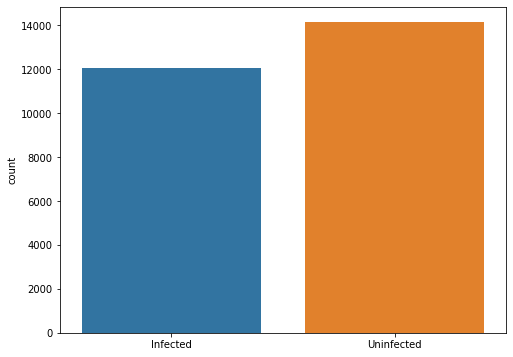

In [5]:
target=pd.Series(y, name='target')
print('Number of infected: {}'.format(target.value_counts()[0]))
print('Number of uninfected: {}'.format(target.value_counts()[1]))

figure=plt.figure(figsize=(8,6))
g1=sns.countplot(x=target)
g1.set_xticklabels(['Infected', 'Uninfected']);
g1.set_xlabel('');

Putting images into numpy arrays

In [6]:
X = np.array(X)
y = np.array(y)

Label encoding

In [7]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)

Splitting data into training and testing

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y.astype(np.int8),
                                                    test_size = 0.2, random_state = 42)

In [9]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((20958, 128, 128, 3), (20958,), (5240, 128, 128, 3), (5240,))

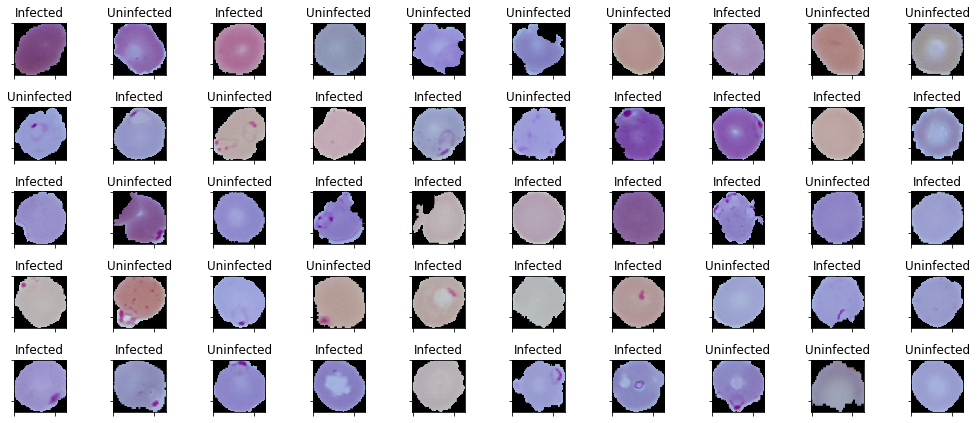

In [10]:
figure, ax = plt.subplots(5,10, figsize = (14,6))
plt.tight_layout()
for row in range(5):
    for col in range(10):
        num = np.random.randint(len(X_train))
        ax[row, col].imshow(X_train[num])
        ax[row, col].tick_params(labelleft=False, labelbottom=False)
        if y[num]==1:
            ax[row, col].set_title('Uninfected')
        else:
            ax[row, col].set_title('Infected')

Data Augmentation

In [11]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rotation_range=40,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip=True,
                                  featurewise_center=True, 
                                  featurewise_std_normalization=True,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2)

train_datagen.fit(X_train)

validation_datagen = ImageDataGenerator(rescale = 1./255)

validation_datagen.fit(X_test)




Using TensorFlow backend.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


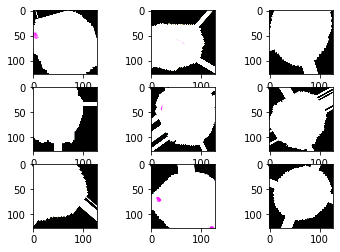

In [13]:
for x_batch, y_batch in train_datagen.flow(X_train, y_train, batch_size=9):
    for i in range(0,9):
        plt.subplot(330 + 1 + i)
        plt.imshow(x_batch[i], cmap = plt.get_cmap('gray'))
    plt.show()
    break

In [14]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dense, Flatten, Dropout, ZeroPadding2D
from keras.layers import LeakyReLU

In [15]:
leaky_relu_alpha = 0.1

model = Sequential()

# 1st Conv Layer
model.add(Conv2D(64, (3,3), strides=(1, 1), padding='same', input_shape=(128, 128, 3)))
model.add(LeakyReLU(alpha=leaky_relu_alpha))
model.add(BatchNormalization())

# 2nd Conv Layer
model.add(Conv2D(64, (3,3), strides=(1, 1), padding='same', input_shape=(128, 128, 3)))
model.add(LeakyReLU(alpha=leaky_relu_alpha))
model.add(BatchNormalization())

# Max Pooling with Dropout Layer
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

# 3rd Conv Layer
model.add(Conv2D(128, (3,3), strides=(1, 1), padding='same'))
model.add(LeakyReLU(alpha=leaky_relu_alpha))
model.add(BatchNormalization())

# 4th Conv Layer
model.add(Conv2D(128, (3,3), strides=(1, 1), padding='same'))
model.add(LeakyReLU(alpha=leaky_relu_alpha))
model.add(BatchNormalization())

# Max Pooling with Dropout Layer
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

# 5th Conv Layer
model.add(Conv2D(256, (3,3), strides=(1, 1), padding='same'))
model.add(LeakyReLU(alpha=leaky_relu_alpha))
model.add(BatchNormalization())

# 6th Conv Layer
model.add(Conv2D(256, (3,3), strides=(1, 1), padding='same'))
model.add(LeakyReLU(alpha=leaky_relu_alpha))
model.add(BatchNormalization())

# Max Pooling with Dropout Layer
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

# 1st FC Dense Layer
model.add(Flatten())
model.add(Dense(256))
model.add(LeakyReLU(alpha=leaky_relu_alpha))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# 2nd FC Dense Layer
model.add(Dense(256))
model.add(LeakyReLU(alpha=leaky_relu_alpha))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Final Dense Layer
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 64)      1792      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)       

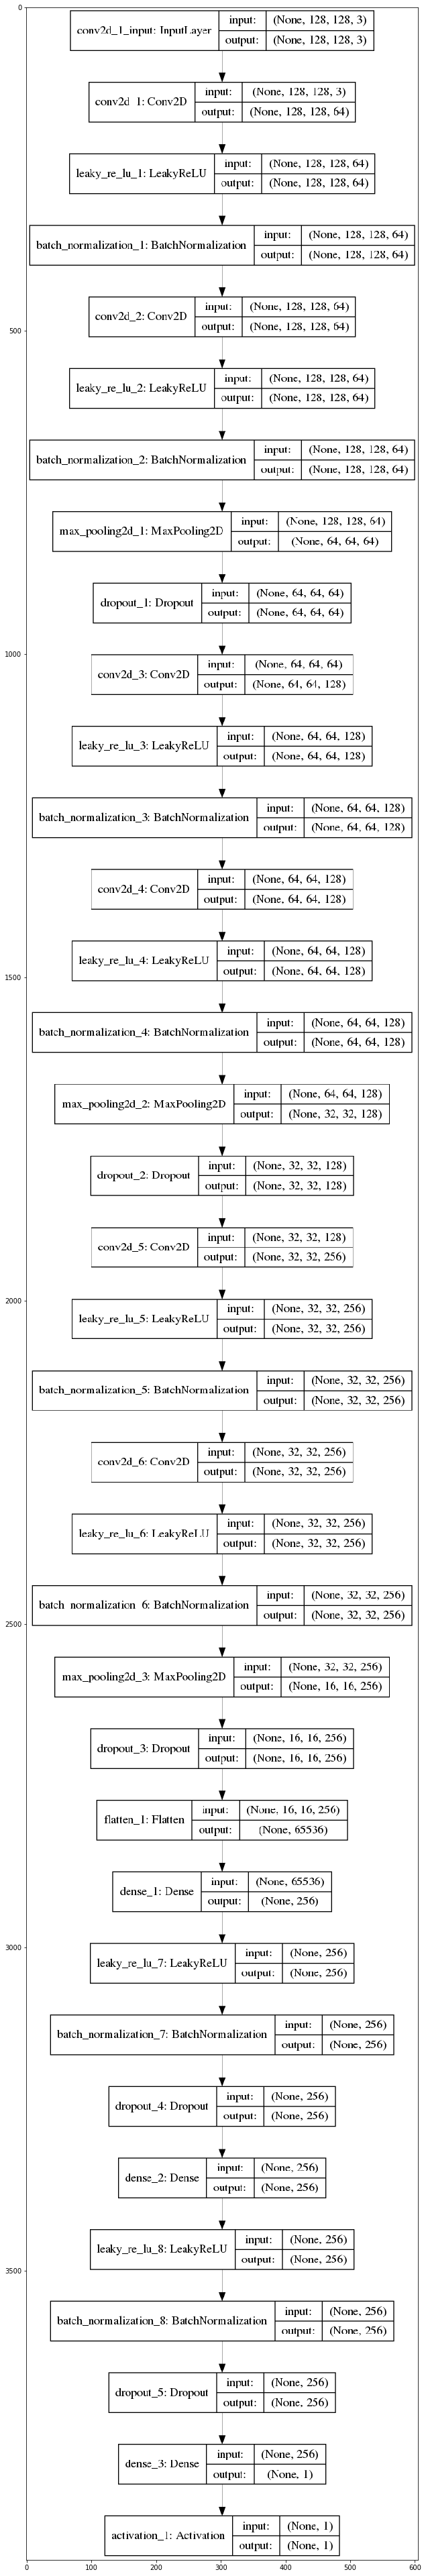

In [16]:
%matplotlib inline
import keras
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

plot_model(model, to_file='MalariaLeakyReLU.png', show_shapes = True, show_layer_names = True)
img = mpimg.imread('MalariaLeakyReLU.png')
plt.figure(figsize = (100,70))
imgplot = plt.imshow(img)

Early Stopping, Reducing LR, Checkpoint Optimzation

In [22]:
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint('MalariaLeakyReLU.h5',
                            monitor = 'val_loss',
                            mode = 'min',
                            save_best_only = True,
                            verbose = 1)

earlystop = EarlyStopping(monitor = 'val_loss',
                         min_delta = 0.0001,
                         patience = 20,
                         verbose = 1,
                         restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                             factor = 0.01,
                             patience = 20,
                             verbose = 1,
                             min_delta = 0.00001)

callbacks = [checkpoint, earlystop, reduce_lr]

model.compile(loss = 'binary_crossentropy',
             optimizer = Adam(lr=0.001, decay = 0.001 / 64),
             metrics = ['accuracy'])


In [23]:
epochs = 100
batch_size = 16

history = model.fit(X_train, y_train, 
                    epochs = epochs, 
                    batch_size = batch_size, 
                    validation_split = 0.2, 
                    callbacks = callbacks)

Train on 16766 samples, validate on 4192 samples
Epoch 1/100
16766/16766 [==============================] - 125s 7ms/step - loss: 0.1106 - accuracy: 0.9693 - val_loss: 0.0871 - val_accuracy: 0.9742

Epoch 00001: val_loss improved from inf to 0.08707, saving model to MalariaLeakyReLU.h5
Epoch 2/100
16766/16766 [==============================] - 123s 7ms/step - loss: 0.0946 - accuracy: 0.9715 - val_loss: 0.0797 - val_accuracy: 0.9757

Epoch 00002: val_loss improved from 0.08707 to 0.07972, saving model to MalariaLeakyReLU.h5
Epoch 3/100
16766/16766 [==============================] - 123s 7ms/step - loss: 0.0826 - accuracy: 0.9754 - val_loss: 0.0839 - val_accuracy: 0.9764

Epoch 00003: val_loss did not improve from 0.07972
Epoch 4/100
16766/16766 [==============================] - 123s 7ms/step - loss: 0.0787 - accuracy: 0.9776 - val_loss: 0.0672 - val_accuracy: 0.9778

Epoch 00004: val_loss improved from 0.07972 to 0.06719, saving model to MalariaLeakyReLU.h5
Epoch 5/100
16766/16766 [===

In [24]:
from keras.models import load_model

best_model = load_model('MalariaLeakyReLU.h5')

In [25]:
test_accuracy = best_model.evaluate(X_test, y_test, verbose = 1)

5240/5240 [==============================] - 14s 3ms/step


In [26]:
print('Accuracy in test set: {:4f}'.format(test_accuracy[1]))

Accuracy in test set: 0.982252


In [27]:
predictions = best_model.predict_classes(X_test)
confusion_matrix(predictions, y_test)

array([[2401,   57],
       [  36, 2746]])

In [28]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      2458
           1       0.98      0.99      0.98      2782

    accuracy                           0.98      5240
   macro avg       0.98      0.98      0.98      5240
weighted avg       0.98      0.98      0.98      5240



In [29]:
cm = confusion_matrix(predictions, y_test)
print('Confusion Matrix: \n', cm)
sensitivity = cm[0,0]/(cm[0,0] + cm[0,1])
print('Sensitivity: {:4f} \n'.format(sensitivity))
specificity = cm[1,1]/(cm[1,0] + cm[1,1])
print('Specificity: {:4f} \n'.format(specificity))

Confusion Matrix: 
 [[2401   57]
 [  36 2746]]
Sensitivity: 0.976810 

Specificity: 0.987060 



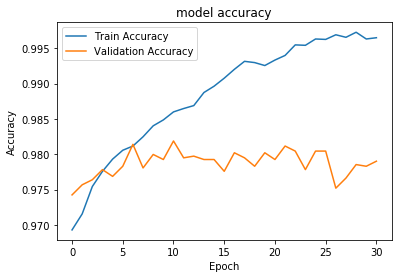

In [37]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
#plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

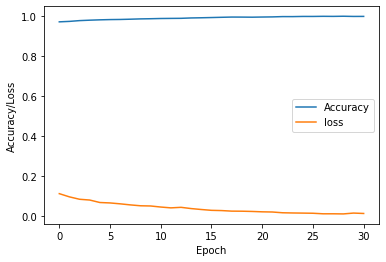

In [42]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"])
#plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
#plt.title("model accuracy")
#plt.title("Accuracy and Loss Vs Epochs")
#plt.title('Model Loss')
#plt.ylabel("Accuracy")
#plt.ylabel("Loss")
plt.ylabel("Accuracy/Loss")
plt.xlabel("Epoch")
#plt.legend(["Train loss","Validation Loss"])
#plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
#plt.legend(["Validation Accuracy"])
plt.legend(["Accuracy","loss"])
plt.show()